In [1]:
!pip -q install yfinance

In [2]:
! pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.6 MB/s eta 0:00:00


1. **Importing Necessary Libraries**

In [3]:
import yfinance as yf

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN

**2. Exploratory Data Analysis**

In [4]:
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

In [5]:
# get historical market data

data =  yf.download('^NSEBANK', start, end)

[*********************100%%**********************]  1 of 1 completed


In [6]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-03-21,39599.648438,39970.898438,39366.300781,39894.699219,39894.699219,187900
2023-03-22,40036.000000,40085.601562,39837.800781,39999.050781,39999.050781,0
2023-03-23,39836.148438,40201.601562,39552.500000,39616.898438,39616.898438,153200
2023-03-24,39555.250000,39767.898438,39294.898438,39395.351562,39395.351562,166100
2023-03-27,39484.699219,39695.199219,39273.750000,39431.300781,39431.300781,194200


In [7]:
data = data.reset_index()
data['Date'] = pd.to_datetime(data['Date'])

# Extract only the date part
data['Date'] = data['Date'].dt.date

In [8]:
data.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

**2.1 Seasonal Decompose**

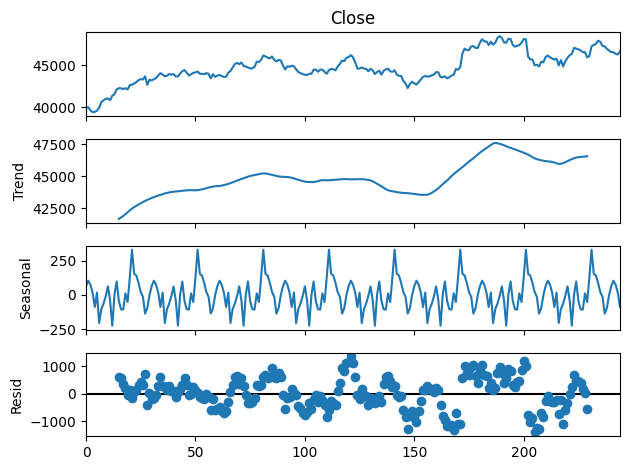

In [9]:
s = seasonal_decompose(data['Close'],period=30)   # 1month
s.plot();

**2.2 Moving Average Plot**

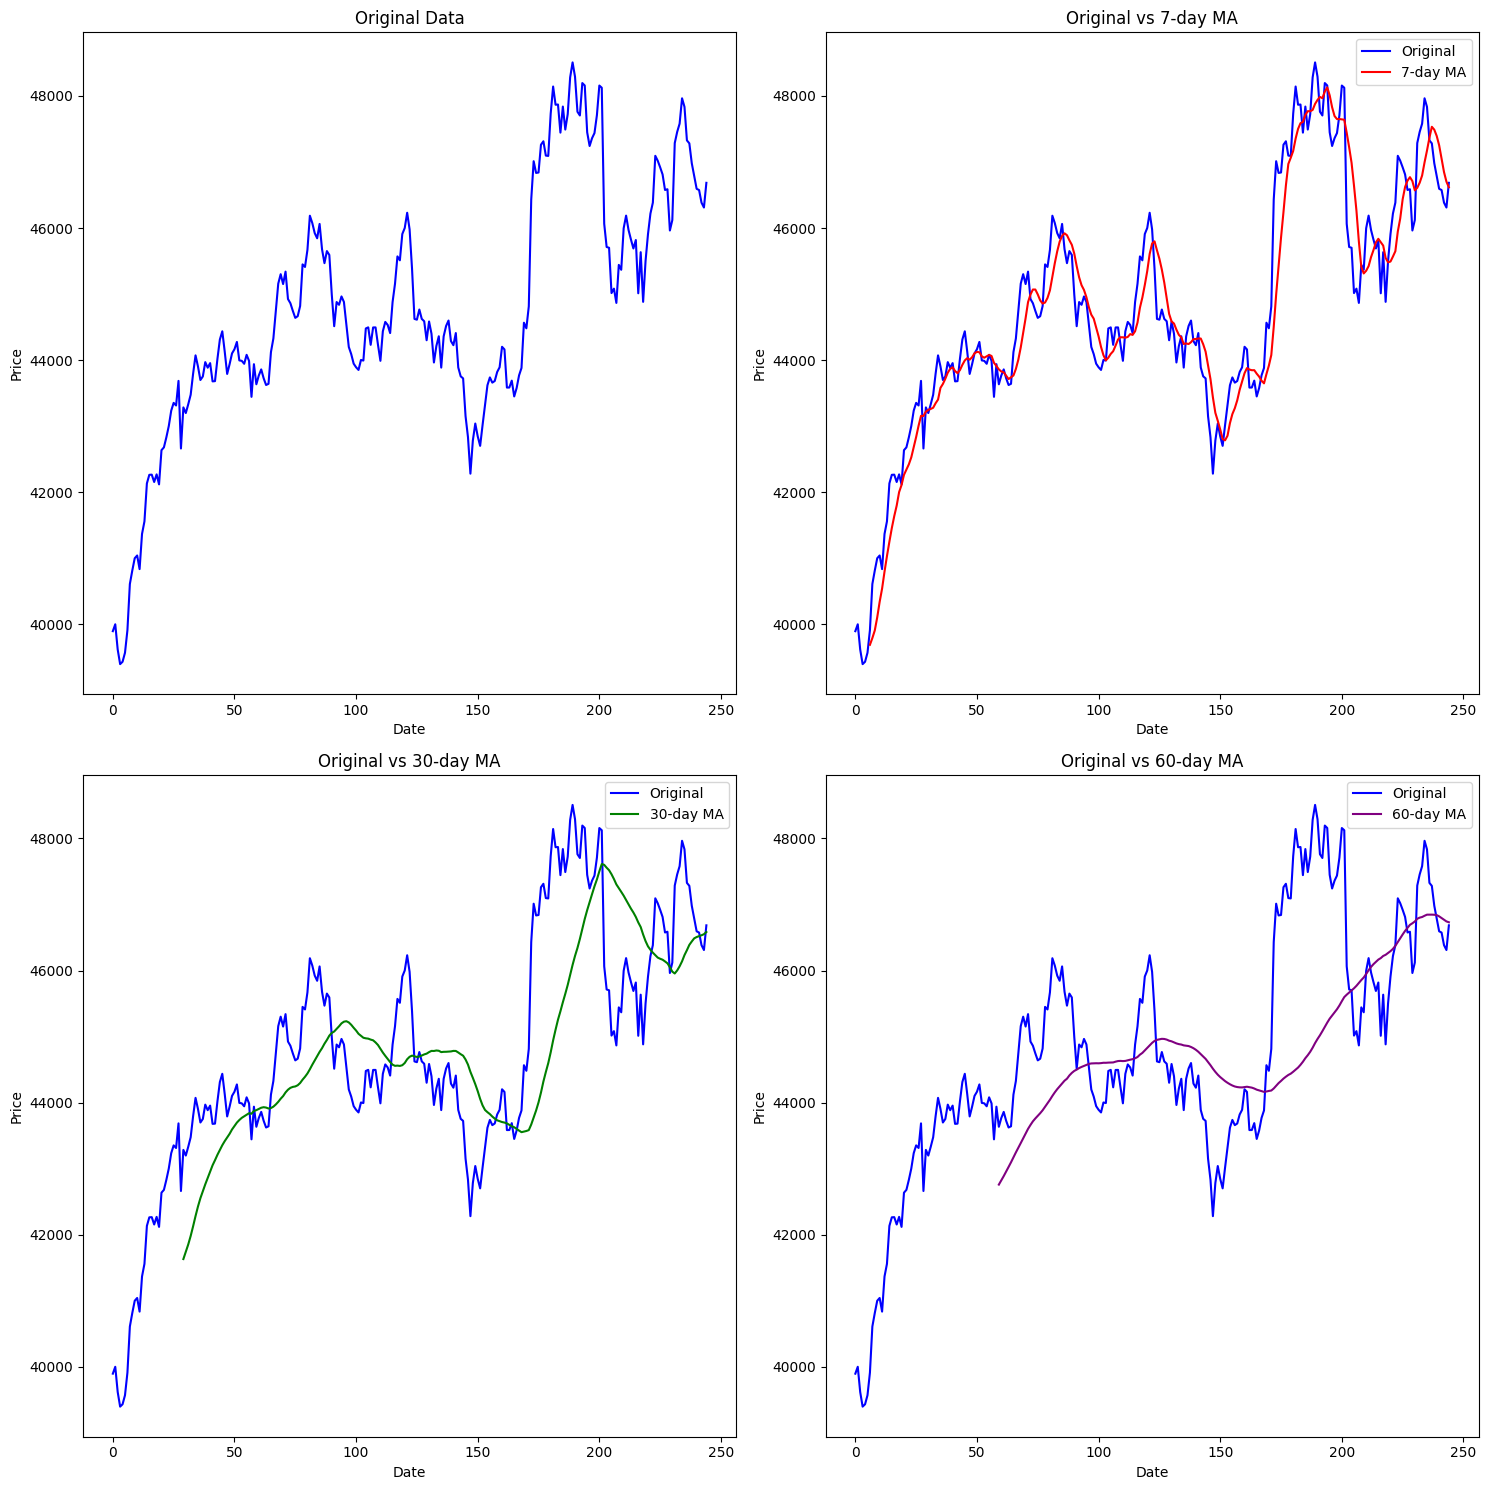

In [10]:
ma_days = [7, 30, 60]

# Calculate moving averages
for ma in ma_days:
    column_name = f"MA for {ma} days"
    data[column_name] = data['Close'].rolling(ma).mean()

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

# Plot original data
axes[0, 0].plot(data['Close'], color='blue')
axes[0, 0].set_title('Original Data')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Price')

# Plot original vs 7-day MA
axes[0, 1].plot(data['Close'], color='blue', label='Original')
axes[0, 1].plot(data['MA for 7 days'], color='red', label='7-day MA')
axes[0, 1].set_title('Original vs 7-day MA')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Price')
axes[0, 1].legend()

# Plot original vs 30-day MA
axes[1, 0].plot(data['Close'], color='blue', label='Original')
axes[1, 0].plot(data['MA for 30 days'], color='green', label='30-day MA')
axes[1, 0].set_title('Original vs 30-day MA')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Price')
axes[1, 0].legend()

# Plot original vs 60-day MA
axes[1, 1].plot(data['Close'], color='blue', label='Original')
axes[1, 1].plot(data['MA for 60 days'], color='purple', label='60-day MA')
axes[1, 1].set_title('Original vs 60-day MA')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Price')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

**2.3 Train - Test Split**

In [11]:
size = int(len(data)*0.80)
training_data = data[:size]
testing_data = data[size:]

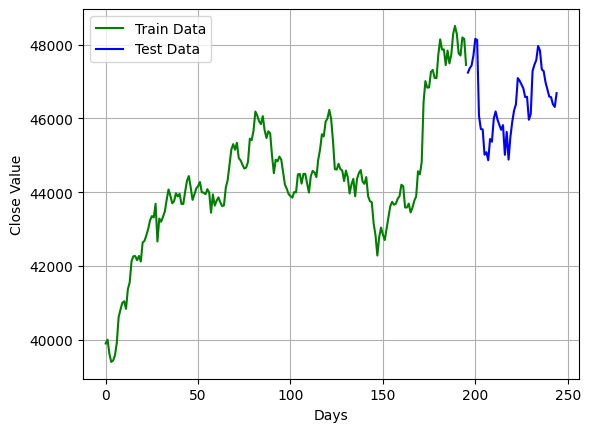

In [12]:
plt.grid(True)
plt.xlabel('Days')
plt.ylabel("Close Value")
plt.plot(training_data['Close'],'green',label = 'Train Data')
plt.plot(testing_data['Close'],'blue',label = 'Test Data')
plt.legend()

**2.4 ACF (Auto Correlation Function)**

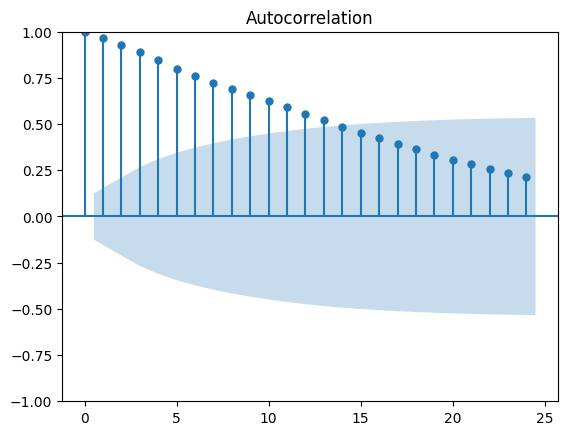

In [13]:
plot_acf(data['Close']);

**2.5 PACF (Partial Auto Correlation Function)**

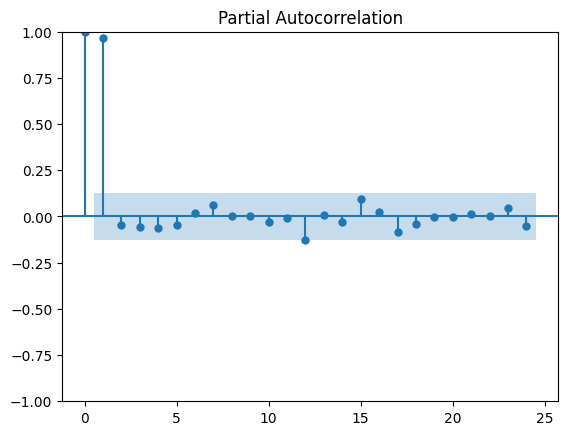

In [14]:
plot_pacf(data['Close']);

**2.6 ADF (Augmented Dickey Fuller Test)**

In [15]:
adf_test = adfuller(data['Close'])
adf_test

(-2.4939886235782245,
 0.11694381724873792,
 0,
 244,
 {'1%': -3.457437824930831,
  '5%': -2.873459364726563,
  '10%': -2.573122099570008},
 3337.674107116532)

In [16]:
print("P-value for Checking Stationarity :",adf_test[1])

P-value for Checking Stationarity : 0.11694381724873792


In [17]:
# HENCE FROM ABOVE RESULTS THE TIME SERIES IS  STATIONARY

**3. Basline Statistical Model Building**

**3.1 pmd ARIMA and SARIMAX**

The pmdarima.auto_arima function takes as input the time series data and a range of values for p, d, and q parameters, and returns an optimized ARIMA model. It uses a combination of iterative and seasonal algorithms to search for the best model.

In [18]:
auto_arima = pm.auto_arima(training_data['Close'],stepwise=False)

In [19]:
auto_arima

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

In [20]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  196
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1403.267
Date:                Thu, 21 Mar 2024   AIC                           2810.534
Time:                        23:38:18   BIC                           2817.080
Sample:                             0   HQIC                          2813.184
                                - 196                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     38.7464     23.351      1.659      0.097      -7.020      84.513
sigma2      1.043e+05   7144.269     14.593      0.000    9.03e+04    1.18e+05
===================================================================================
Ljung-Box (L1) (Q):                   2.06   Jarque-Bera (JB):                51.78
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               1.77   Skew:                             0.29
Prob(H) (two-sided):                  0.02   Kurtosis:                         5.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
model = sm.tsa.SARIMAX(training_data['Close'], order=(0, 1, 1), trend='c')

In [22]:
# Fit the model
results = model.fit()

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  196
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1402.365
Date:                Thu, 21 Mar 2024   AIC                           2810.730
Time:                        23:38:24   BIC                           2820.549
Sample:                             0   HQIC                          2814.705
                                - 196                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     37.2047     25.030      1.486      0.137     -11.853      86.262
ma.L1          0.0809      0.057      1.430      0.153      -0.030       0.192
sigma2      1.027e+05   7195.357     14.274      0.0

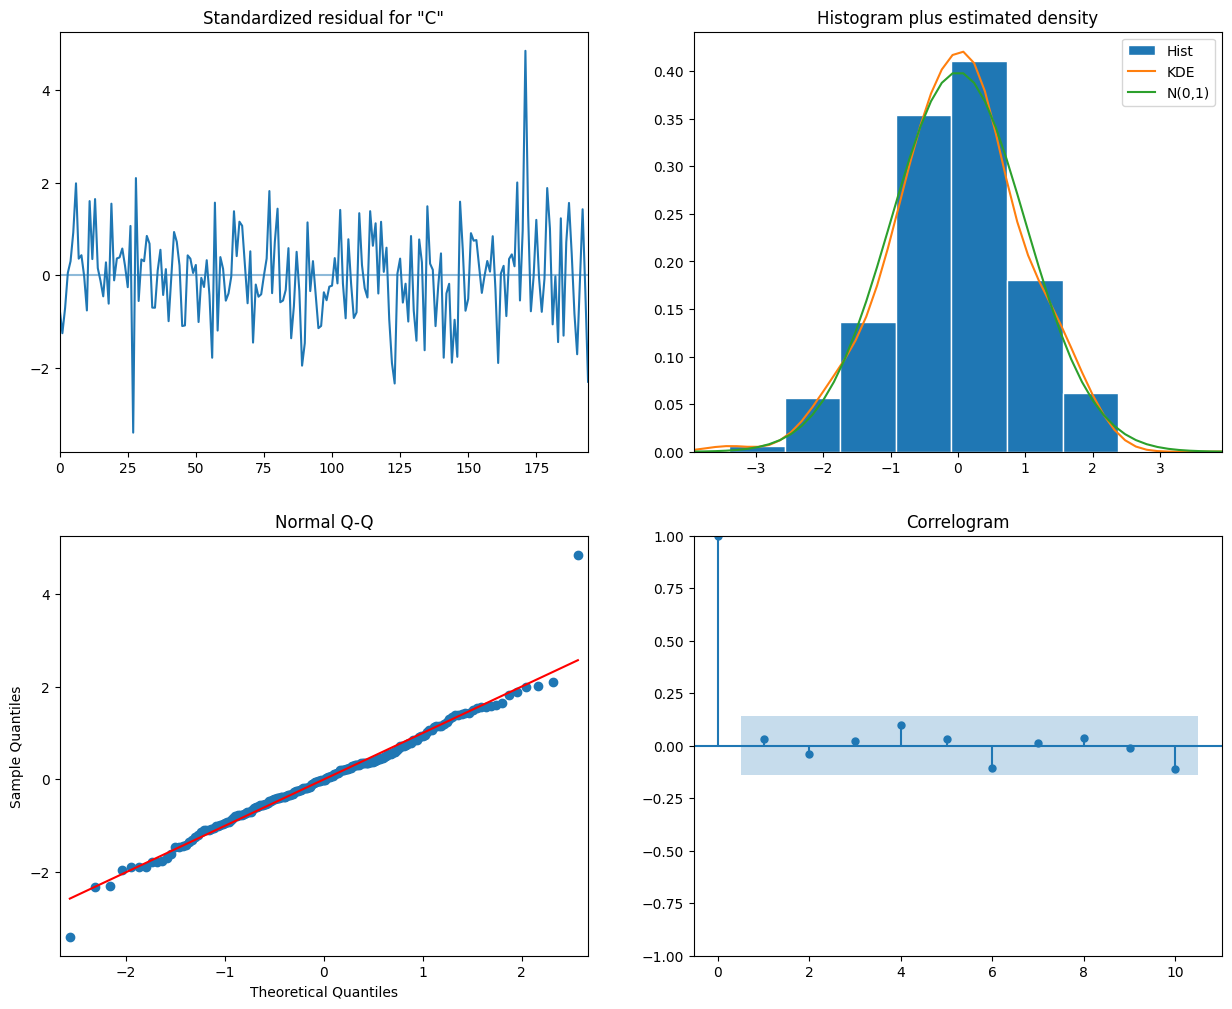

In [23]:
# Print model summary
print(results.summary())

# Plot diagnostics
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [24]:
forecast_test = results.forecast(len(testing_data))

In [25]:
pred = pd.DataFrame(forecast_test)

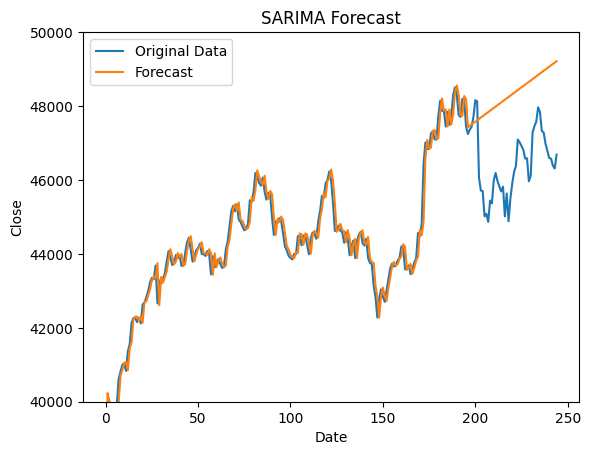

In [26]:
# Forecast for both training and testing data
forecast_train = results.predict(start=training_data.index[0], end=training_data.index[-1])
forecast_test = results.predict(start=testing_data.index[0], end=testing_data.index[-1])

# Assign the forecasts to the DataFrame
data['forecast_auto'] = pd.concat([forecast_train, forecast_test])

# Plot the original data and the forecasts
data['Close'].plot(label='Original Data')
data['forecast_auto'].plot(label='Forecast')
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('SARIMA Forecast')
plt.legend()

# Set the y-axis limits to zoom in on the range from 40000 to 50000
plt.ylim(40000, 50000)

plt.show()

**Pipeline**

Input Data -> Minmax scalar ->Making Sequences -> LSTM -> Prediction -> plotting

**Experimentation**

**1.Window size of sequences :**

    1.1 Taking 60 ( 2 month ) as window size cannot capture the upward trend and doesnot predict well

    1.2 Whereas Taking window size of 30 ( one month ) gives the best prediction and low rmse value and thus optimal for forecasting.

    1.3 While Taking window size of 7 ( one week ) could capture the upward trend, whereas the downward trend is not captured , thus having high rmse and less accurate prediction


                    

# **4.1 Model 1 : Window size = 30days (Optimal)**


In [27]:
# Create a new dataframe with only the 'Close column
data_close = data.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data_close.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .80 ))

training_data_len

196

In [28]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler(feature_range=(0,1))
scaled_data = minmax.fit_transform(dataset)

In [29]:
dataset[:3],scaled_data[:3]

(array([[39894.69921875],
        [39999.05078125],
        [39616.8984375 ]]),
 array([[0.05479389],
        [0.06624449],
        [0.02431055]]))

In [30]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(30, len(train_data)):
    x_train.append(train_data[i-30:i, 0])
    y_train.append(train_data[i, 0])


# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [31]:
# Displaying the shape x_train

x_train.shape

(166, 30, 1)

In [32]:
# Build the LSTM model1
model1 = Sequential()
model1.add(LSTM(256, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model1.add(LSTM(128, return_sequences=True))
model1.add(LSTM(64, return_sequences=False))
model1.add(Dense(25))
model1.add(Dense(10))
model1.add(Dense(1))

# Compile the model1
model1.compile(optimizer='adam', loss='mean_squared_error')
# Train the model1
model1.fit(x_train, y_train, batch_size=1, epochs=25)

Epoch 1/25
166/166 [==============================] - 19s 75ms/step - loss: 0.0260
Epoch 2/25
166/166 [==============================] - 13s 80ms/step - loss: 0.0097
Epoch 3/25
166/166 [==============================] - 12s 74ms/step - loss: 0.0087
Epoch 4/25
166/166 [==============================] - 12s 73ms/step - loss: 0.0083
Epoch 5/25
166/166 [==============================] - 12s 73ms/step - loss: 0.0045
Epoch 6/25
166/166 [==============================] - 12s 74ms/step - loss: 0.0048
Epoch 7/25
166/166 [==============================] - 12s 75ms/step - loss: 0.0034
Epoch 8/25
166/166 [==============================] - 12s 70ms/step - loss: 0.0034
Epoch 9/25
166/166 [==============================] - 14s 86ms/step - loss: 0.0031
Epoch 10/25
166/166 [==============================] - 13s 76ms/step - loss: 0.0033
Epoch 11/25
166/166 [==============================] - 12s 74ms/step - loss: 0.0026
Epoch 12/25
166/166 [==============================] - 12s 73ms/step - loss: 0.0024
E

In [33]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002
test_data = scaled_data[training_data_len - 30: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(30, len(test_data)):
    x_test.append(test_data[i-30:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))


# Get the models predicted price values
predictions_model1 = model1.predict(x_test)
predictions_model1 = minmax.inverse_transform(predictions_model1)

# Get the root mean squared error (RMSE)
rmse_model1 = np.sqrt(np.mean(((predictions_model1 - y_test) ** 2)))
rmse_model1

2/2 [==============================] - 2s 38ms/step


733.6436373785288

<ipython-input-40-7bc8ed003087>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions_model1


Text(0.5, 1.0, 'Prediction with the window size of 30 ( 1 month ) ')

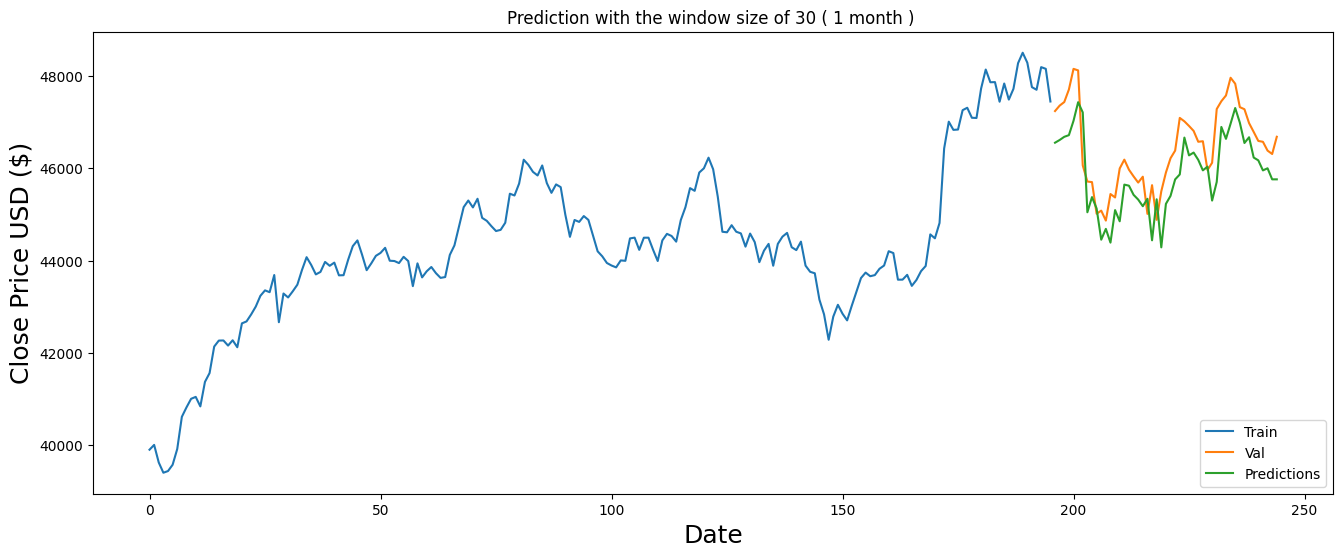

In [40]:
#  Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions_model1
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.title("Prediction with the window size of 30 ( 1 month ) ")

# **4.2 Model 2 : Window Size = 60days (comparision 1)**


In [41]:
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]

# Split the data into x_train and y_train data sets

x_train = []
y_train = []

for i in range(60, len(train_data)):          # 60 as window size
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

In [42]:
x_train.shape

(136, 60, 1)

In [43]:
# Build the LSTM model2
model2 = Sequential()
model2.add(LSTM(256, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model2.add(LSTM(128, return_sequences=True))
model2.add(LSTM(64, return_sequences=False))
model2.add(Dense(25))
model2.add(Dense(10))
model2.add(Dense(1))

# Compile the model2
model2.compile(optimizer='adam', loss='mean_squared_error')

# Train the model2
model2.fit(x_train, y_train, batch_size=1, epochs=25)

Epoch 1/25
136/136 [==============================] - 27s 152ms/step - loss: 0.0270
Epoch 2/25
136/136 [==============================] - 21s 156ms/step - loss: 0.0119
Epoch 3/25
136/136 [==============================] - 21s 156ms/step - loss: 0.0091
Epoch 4/25
136/136 [==============================] - 21s 156ms/step - loss: 0.0082
Epoch 5/25
136/136 [==============================] - 21s 156ms/step - loss: 0.0055
Epoch 6/25
136/136 [==============================] - 22s 158ms/step - loss: 0.0057
Epoch 7/25
136/136 [==============================] - 20s 149ms/step - loss: 0.0038
Epoch 8/25
136/136 [==============================] - 21s 155ms/step - loss: 0.0035
Epoch 9/25
136/136 [==============================] - 23s 172ms/step - loss: 0.0033
Epoch 10/25
136/136 [==============================] - 21s 152ms/step - loss: 0.0044
Epoch 11/25
136/136 [==============================] - 21s 156ms/step - loss: 0.0034
Epoch 12/25
136/136 [==============================] - 22s 163ms/step - lo

In [44]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))


# Get the models predicted price values
predictions_model2 = model2.predict(x_test)
predictions_model2 = minmax.inverse_transform(predictions_model2)

# Get the root mean squared error (RMSE)
rmse_model2 = np.sqrt(np.mean(((predictions_model2 - y_test) ** 2)))
rmse_model2

2/2 [==============================] - 2s 60ms/step


587.3292856840518

<ipython-input-45-b38afa41f738>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions_model2


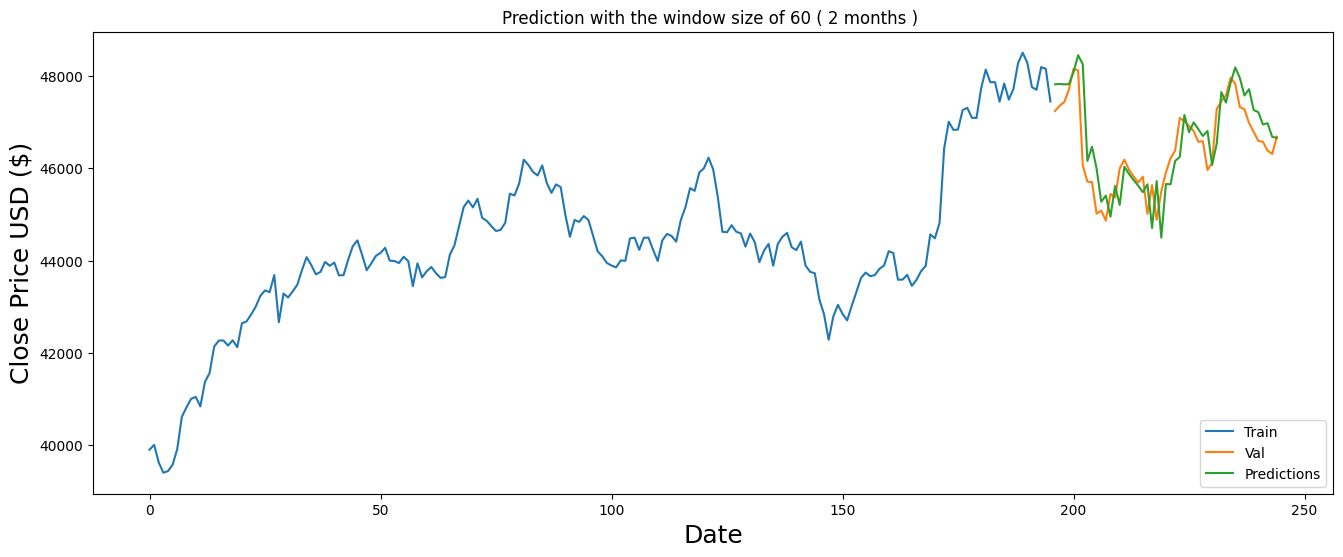

In [45]:
#  Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions_model2
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.title("Prediction with the window size of 60 ( 2 months ) ")
plt.show()

# **4.3 Model 3 : Window Size = 7 days (comparision 2)**

In [46]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(7, len(train_data)):
    x_train.append(train_data[i-7:i, 0])
    y_train.append(train_data[i, 0])

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

In [48]:
# Build the LSTM model3
model3 = Sequential()
model3.add(LSTM(256, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model3.add(LSTM(128, return_sequences=True))
model3.add(LSTM(64, return_sequences=False))
model3.add(Dense(25))
model3.add(Dense(10))
model3.add(Dense(1))

# Compile the model3
model3.compile(optimizer='adam', loss='mean_squared_error')

# Train the model3
model3.fit(x_train, y_train, batch_size=1, epochs=25)

Epoch 1/25
189/189 [==============================] - 17s 29ms/step - loss: 0.0220
Epoch 2/25
189/189 [==============================] - 4s 23ms/step - loss: 0.0100
Epoch 3/25
189/189 [==============================] - 4s 23ms/step - loss: 0.0087
Epoch 4/25
189/189 [==============================] - 6s 29ms/step - loss: 0.0071
Epoch 5/25
189/189 [==============================] - 4s 23ms/step - loss: 0.0091
Epoch 6/25
189/189 [==============================] - 5s 27ms/step - loss: 0.0064
Epoch 7/25
189/189 [==============================] - 5s 25ms/step - loss: 0.0049
Epoch 8/25
189/189 [==============================] - 4s 23ms/step - loss: 0.0041
Epoch 9/25
189/189 [==============================] - 6s 30ms/step - loss: 0.0042
Epoch 10/25
189/189 [==============================] - 4s 23ms/step - loss: 0.0034
Epoch 11/25
189/189 [==============================] - 4s 23ms/step - loss: 0.0021
Epoch 12/25
189/189 [==============================] - 5s 29ms/step - loss: 0.0022
Epoch 13/25


In [49]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002
test_data = scaled_data[training_data_len - 7: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(7, len(test_data)):
    x_test.append(test_data[i-7:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))


# Get the models predicted price values
predictions_model3 = model3.predict(x_test)
predictions_model3 = minmax.inverse_transform(predictions_model3)

# Get the root mean squared error (RMSE)
rmse_model3 = np.sqrt(np.mean(((predictions_model3 - y_test) ** 2)))
rmse_model3

2/2 [==============================] - 3s 21ms/step


470.3892316566912

<ipython-input-50-e7486efa8ade>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions_model3


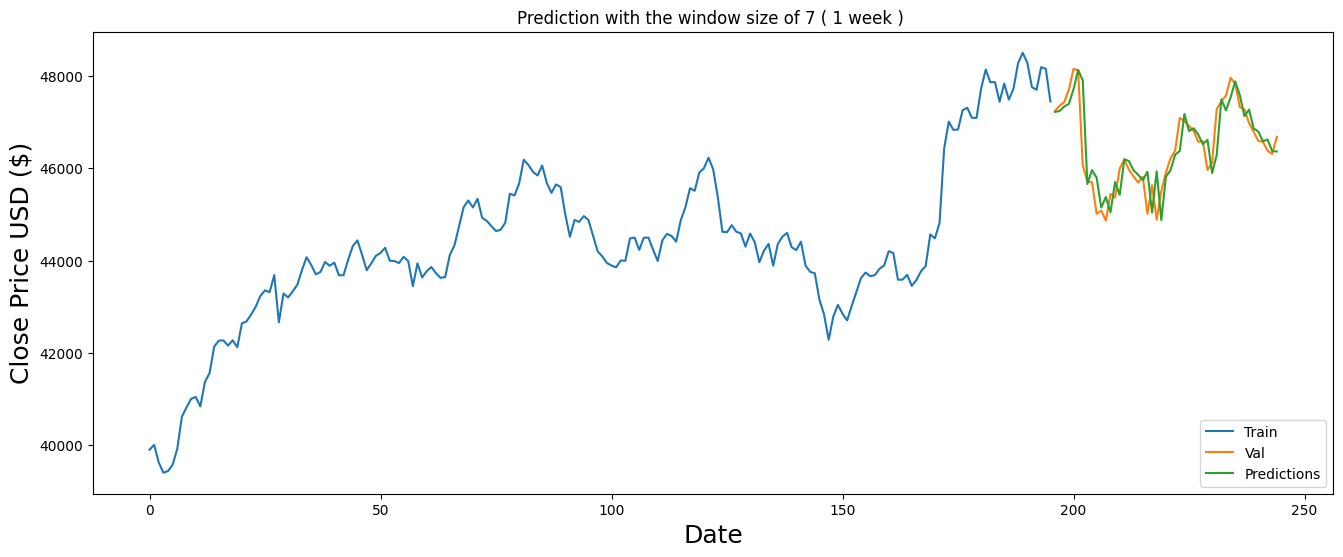

In [50]:
#  Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions_model3
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.title("Prediction with the window size of 7 ( 1 week ) ")
plt.show()

In [51]:
predictions_model3

array([[47224.004],
       [47245.27 ],
       [47342.008],
       [47397.734],
       [47716.3  ],
       [48135.05 ],
       [47906.785],
       [45658.01 ],
       [45962.76 ],
       [45797.254],
       [45149.754],
       [45376.562],
       [45045.21 ],
       [45704.37 ],
       [45424.258],
       [46198.902],
       [46155.695],
       [45957.137],
       [45861.08 ],
       [45744.805],
       [45924.94 ],
       [45038.234],
       [45932.81 ],
       [44876.5  ],
       [45818.844],
       [45958.527],
       [46297.4  ],
       [46375.05 ],
       [47180.645],
       [46808.79 ],
       [46869.273],
       [46731.594],
       [46522.555],
       [46618.254],
       [45896.64 ],
       [46293.387],
       [47497.06 ],
       [47258.246],
       [47538.72 ],
       [47888.42 ],
       [47586.68 ],
       [47132.156],
       [47273.613],
       [46863.152],
       [46798.883],
       [46587.312],
       [46624.65 ],
       [46376.32 ],
       [46364.99 ]], dtype=float32)

In [52]:
# Get the models predicted price values
predictions_model3 = model3.predict(x_test)
predictions_model3 = minmax.inverse_transform(predictions_model3)

# Get the root mean squared error (RMSE)
rmse_model3 = np.sqrt(np.mean(((predictions_model3 - y_test) ** 2)))
rmse_model3

2/2 [==============================] - 0s 12ms/step


470.3892316566912

In [53]:
# Get the models predicted price values
predictions_model2 = model2.predict(x_test)
predictions_model2 = minmax.inverse_transform(predictions_model2)

# Get the root mean squared error (RMSE)
rmse_model2 = np.sqrt(np.mean(((predictions_model2 - y_test) ** 2)))
rmse_model2

2/2 [==============================] - 1s 14ms/step


538.7104625460025

 # **RMSE Comparison**

In [54]:
print("RMSE LSTM with 30 days window")
rmse_model1

RMSE LSTM with 30 days window


733.6436373785288

In [55]:
print("RMSE LSTM with 60 days window")
rmse_model2

RMSE LSTM with 60 days window


538.7104625460025

In [56]:
print("RMSE LSTM with 7 days window")
rmse_model3

RMSE LSTM with 7 days window


470.3892316566912